## Predicting

**Importing librairies**


In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd


/lhome/malanm/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [2]:
filename_1 = "../data/_tarefelt1.csv"

In [3]:
data_1 = pd.read_csv(filename_1)
X = data_1

**Unbalanced**

In [4]:
X_sampled = X.drop(X[X['label'] == 0].sample(frac=.80).index)

In [5]:
X = X_sampled


In [6]:
X.drop(columns = "Unnamed: 0",  inplace = True)

**Feature Selection**

In [7]:
X.drop(columns = ['band_0', 'band_1', 'band_2'], inplace = True)

**Splitting data**

Creating balanced datasets using stratified shuffle split

In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, X.label)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]


**Feature extracting**

In [9]:
y_train = X_train.label
X_train.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)


lat = X_test.lat
lon = X_test.lon
y_test = X_test.label
X_test.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

**Standarscaling**


In [10]:
scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)

**Sjekke accuracy**

In [39]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss='log_loss',  
                    warm_start = True, 
                    penalty = "l2",
                    class_weight= dict(zip(np.unique(y_train), class_weights)), 
                    learning_rate = "optimal",

                     random_state = 42,
                    alpha = 0.001
                    )

NROUNDS = 50
skf = StratifiedKFold(shuffle=True, n_splits=NROUNDS)
cv_results_skfold_1 = cross_val_score(clf, X_train, y_train, cv=skf, scoring='precision')

In [40]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss='log_loss', 
                    warm_start = False, 
                    penalty = "l2",
                    learning_rate = "optimal",

                     random_state = 42,
                    class_weight= dict(zip(np.unique(y_train), class_weights)),
                    alpha = 0.001
                    )
NROUNDS = 50
skf = StratifiedKFold(shuffle=True, n_splits=NROUNDS)
cv_results_skfold_2 = cross_val_score(clf, X_train, y_train, cv=skf, scoring='precision')

In [33]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss='log_loss', 
                    warm_start = True, 
                    penalty = "l2",
                    learning_rate = "optimal",

                     random_state = 42,
                    class_weight= dict(zip(np.unique(y_train), class_weights)),
                    alpha = 0.001
                    )
NROUNDS = 50
skf = StratifiedKFold(shuffle=True, n_splits=NROUNDS)
cv_results_skfold_3 = cross_val_score(clf, X_train, y_train, cv=skf, scoring='precision')

**Plotting accuracy**

Text(0.5, 0.98, 'Sammenligner ulike verdier for warm start.')

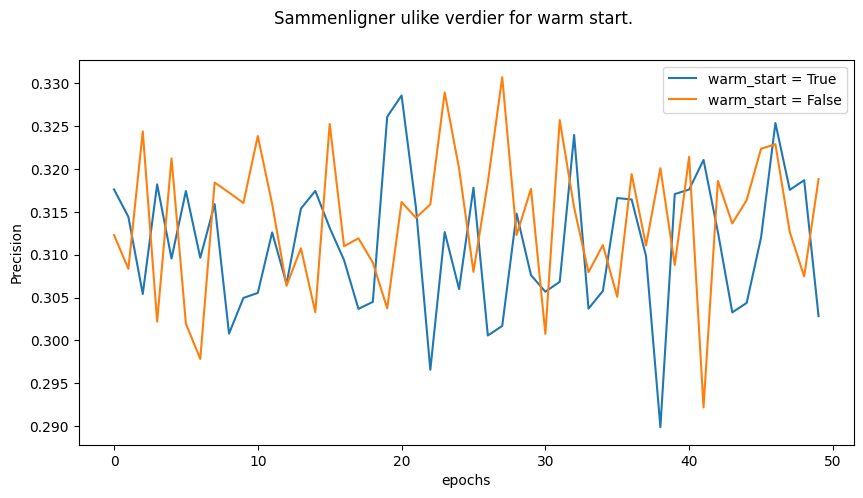

In [41]:
fig, ax1 = plt.subplots(1, figsize = (10,5))
ax1.plot(cv_results_skfold_1, label ="warm_start = True")
ax1.plot(cv_results_skfold_2,label = "warm_start = False")
ax1.legend()
ax1.set_xlabel("epochs")
ax1.set_ylabel("Precision")
fig.suptitle("Sammenligner ulike verdier for warm start.")

In [72]:

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = make_pipeline(StandardScaler(),SGDClassifier(loss = "modified_huber"
                    warm_start = True, 
                    penalty = "l2", 
                    class_weight= dict(zip(np.unique(y_train), class_weights))))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight={0.0: 0.5283953806501611,
                                             1.0: 9.304248940349426},
                               loss='modified_huber', warm_start=True))])

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [86]:
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
X_final = X_test.copy()
X_final["label"] = y_test
X_final["y_predicted"] = y_predicted
X_final = gpd.GeoDataFrame(X_final, geometry=gpd.points_from_xy(lon, lat))

df_no_seaweed = X_final[X_final["y_predicted"] == 0].copy()
df_seaweed = X_final[X_final["y_predicted"] == 1].copy()
df_true_seaweed = X_final[X_final["label"] == True].copy()

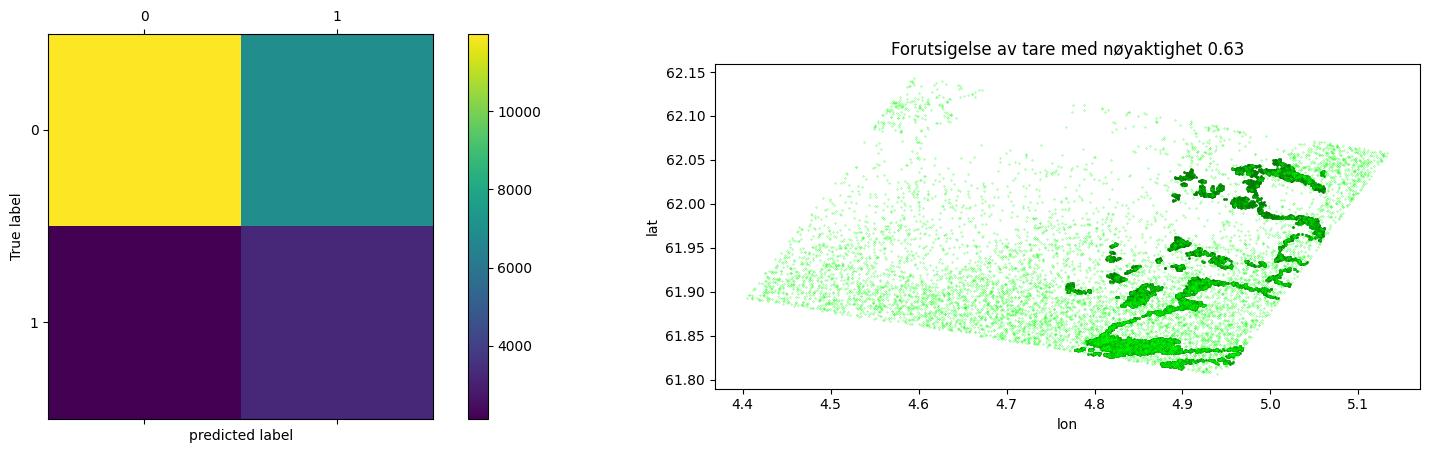

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2 ,figsize = (20,5))
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)

im = ax1.matshow(conf_mat)
ax1.set_ylabel("True label")
ax1.set_xlabel("predicted label")

df_true_seaweed.plot(ax = ax2, color = "green", label = "Tare", markersize = 1)
df_seaweed.plot(ax = ax2, color = "lime", label = "Forutsatt tare", markersize = 0.05)

ax2.set_title(f"Forutsigelse av tare med nøyaktighet {np.round(accuracy,2)}")
ax2.set_xlabel("lon")
ax2.set_ylabel("lat")
fig.colorbar(im)



In [2]:
print("YOLOV5")

YOLOV5
